In [1]:
import keras
# import tensorflow as tf
from tensorflow import keras
import re
import numpy as np
import pandas as pd

from functools import partial
import matplotlib.pyplot as plt

from readTFRecords import *

# import tensorflow_hub as hub
# from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications import EfficientNetB0


from sklearn.model_selection import train_test_split

# AUTOTUNE = tf.data.experimental.AUTOTUNE
GCS_PATH = "../input/train_tfrecords"
# BATCH_SIZE = 16
# IMAGE_SIZE = (224, 512)
CLASSES = ['0', '1', '2', '3', '4']
NUM_CLASSES = len(CLASSES)
EPOCHS = 12

FILENAMES = tf.io.gfile.glob(GCS_PATH + "/*tfrec")
split_ind = int(0.9 * len(FILENAMES))
# TRAINING_FILENAMES, VALID_FILENAMES = FILENAMES[:split_ind], FILENAMES[split_ind:]

TRAINING_FILENAMES, VALID_FILENAMES = train_test_split(FILENAMES, test_size=0.2, random_state=420)

TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + "../input/test_tfrecords/*tfrec")
print("Train TFRecord Files:", len(TRAINING_FILENAMES))
print("Validation TFRecord Files:", len(VALID_FILENAMES))
print("Test TFRecord Files:", len(TEST_FILENAMES))

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALID_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)

print('Dataset: {} training images, {} validation images, {} (unlabeled) test images'.format(
    NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

Train TFRecord Files: 12
Validation TFRecord Files: 4
Test TFRecord Files: 0
Dataset: 16045 training images, 5352 validation images, 0.0 (unlabeled) test images


In [2]:
import efficientnet.keras as eff
from tensorflow.keras.experimental import CosineDecay

In [3]:
BATCH_SIZE = 12
epochs = 8

decay_steps = int(round(NUM_TRAINING_IMAGES/BATCH_SIZE))*epochs
cosine_decay = CosineDecay(initial_learning_rate=1e-4, decay_steps=decay_steps, alpha=0.3)

from keras.backend import sigmoid

class SwishActivation(tf.keras.layers.Activation):
    
    def __init__(self, activation, **kwargs):
        super(SwishActivation, self).__init__(activation, **kwargs)
        self.__name__ = 'swish_act'

def swish_act(x, beta = 1):
    return (x * sigmoid(beta * x))

from keras.utils.generic_utils import get_custom_objects
# from tf.keras.layers import Activation
get_custom_objects().update({'swish_act': SwishActivation(swish_act)})

data_augmentation_layers = tf.keras.Sequential(
    [
#         tf.keras.layers.experimental.preprocessing.RandomCrop(height=IMAGE_SIZE[0], width=IMAGE_SIZE[1]),
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.25),
        tf.keras.layers.experimental.preprocessing.RandomContrast((0.2,0.8)),
        tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=0.4, width_factor=0.3)
    ], 
    name="img_augmentation"
)

def buildModel():
    inputs = tf.keras.layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    x = data_augmentation_layers(inputs)
    model = tf.keras.applications.MobileNetV3Large(include_top=False, input_tensor=x, weights="imagenet")
#     model = eff.EfficientNetB0(include_top=False, input_tensor=x, weights='noisy-student')


    # Freeze the pretrained weights
    # model.trainable = False

    # Rebuild top
    x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = tf.keras.layers.BatchNormalization()(x)

#     top_dropout_rate = 0.2
#     x = tf.keras.layers.Dropout(top_dropout_rate, name="top_dropout")(x)

#     x = tf.keras.layers.BatchNormalization()(x)
#     x = tf.keras.layers.Dropout(0.3)(x)

#     x = tf.keras.layers.Dense(1024)(x)
#     x = tf.keras.layers.BatchNormalization()(x)
#     x = tf.keras.layers.Activation(swish_act)(x)
#     x = tf.keras.layers.Dropout(0.3)(x)

#     x = tf.keras.layers.Dense(1024)(x)
#     x = tf.keras.layers.BatchNormalization()(x)
#     x = tf.keras.layers.Activation(swish_act)(x)

#     outputs = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

    top_dropout_rate = 0.2
    x = tf.keras.layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    
    return model

In [4]:
NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALID_FILENAMES)

train_dataset = get_training_dataset(TRAINING_FILENAMES, BATCH_SIZE)
valid_dataset = get_validation_dataset(VALID_FILENAMES, BATCH_SIZE)

STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
VALID_STEPS = NUM_VALIDATION_IMAGES // BATCH_SIZE

# model = buildModel()

inputs = tf.keras.layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

# base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_tensor=inputs)
base_model = tf.keras.applications.InceptionResNetV2(weights='imagenet', include_top=False, input_tensor=inputs)
# base_model = eff.EfficientNetB2(include_top=False, input_tensor=inputs, weights='noisy-student')
#     base_model.trainable = False

# model = tf.keras.Sequential([
# #         tf.keras.layers.BatchNormalization(renorm=True),
# #         img_adjust_layer,
#     base_model,
#     tf.keras.layers.GlobalAveragePooling2D(),
#     tf.keras.layers.Dense(len(CLASSES), activation='softmax')  
# ])

top_dropout_rate = 0.2

model = tf.keras.Sequential([
#         tf.keras.layers.BatchNormalization(renorm=True),
#         img_adjust_layer,
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(top_dropout_rate, name="top_dropout"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(512),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation(swish_act),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(256),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation(swish_act),
    
    tf.keras.layers.Dense(len(CLASSES), activation='softmax')  
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
#         optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',  
    metrics=['accuracy'])

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 5, 5, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
batch_normalization_203 (Bat (None, 1536)              6144      
_________________________________________________________________
top_dropout (Dropout)        (None, 1536)              0         
_________________________________________________________________
batch_normalization_204 (Bat (None, 1536)              6144      
_________________________________________________________________
dropout (Dropout)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               7

In [6]:
for image,l in train_dataset.take(1):
    print(image.shape)

(12, 224, 224, 3)


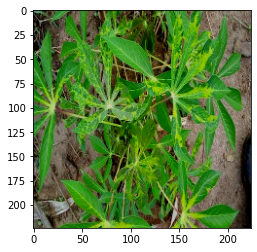

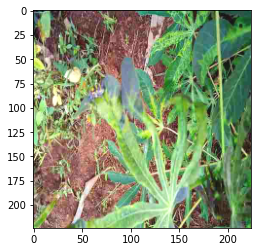

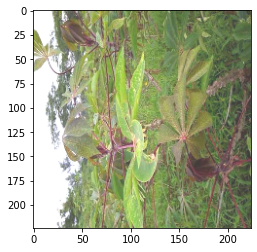

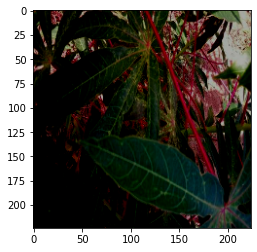

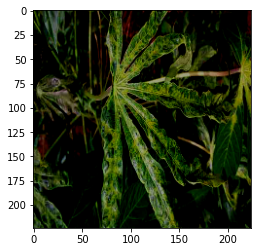

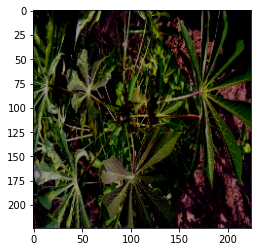

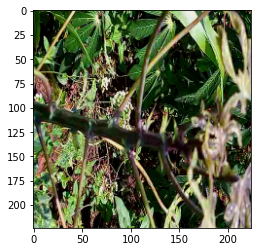

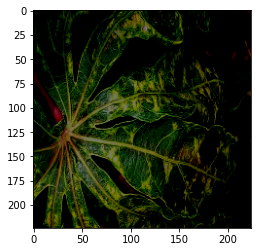

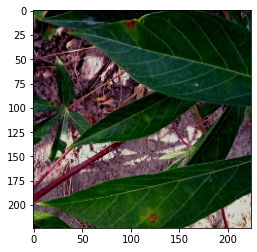

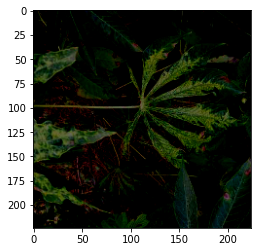

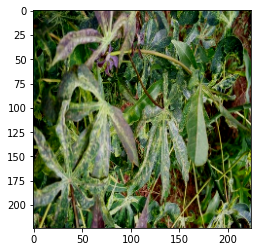

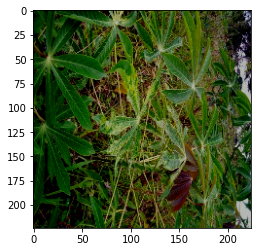

In [7]:
for i in range(BATCH_SIZE):
    plt.imshow(image[i]/255.0)
    plt.show()

In [8]:
# model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(cosine_decay), 
#                   metrics=["accuracy"])

In [9]:
history = model.fit(train_dataset, 
                        steps_per_epoch=STEPS_PER_EPOCH, 
                        epochs=8,
                        validation_data=valid_dataset,
                        validation_steps=VALID_STEPS,)

Epoch 1/8
1337/1337 [==============================] - 322s 221ms/step - loss: 1.1095 - accuracy: 0.6035 - val_loss: 1.1451 - val_accuracy: 0.6446
Epoch 2/8
1337/1337 [==============================] - 291s 217ms/step - loss: 0.9291 - accuracy: 0.6616 - val_loss: 3.7455 - val_accuracy: 0.6521
Epoch 3/8
1337/1337 [==============================] - 285s 213ms/step - loss: 0.8636 - accuracy: 0.6838 - val_loss: 1.0625 - val_accuracy: 0.5955
Epoch 4/8
1337/1337 [==============================] - 291s 218ms/step - loss: 0.8743 - accuracy: 0.6732 - val_loss: 1.5887 - val_accuracy: 0.6581
Epoch 5/8
1337/1337 [==============================] - 294s 220ms/step - loss: 0.8334 - accuracy: 0.6848 - val_loss: 0.9346 - val_accuracy: 0.6915
Epoch 6/8
1337/1337 [==============================] - 286s 214ms/step - loss: 0.7647 - accuracy: 0.7189 - val_loss: 54.6690 - val_accuracy: 0.1297
Epoch 7/8
1337/1337 [==============================] - 287s 214ms/step - loss: 0.7756 - accuracy: 0.7199 - val_loss: 

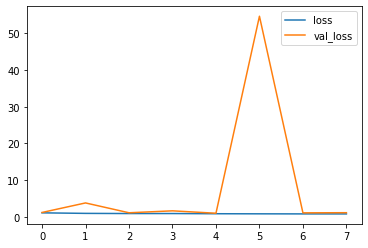

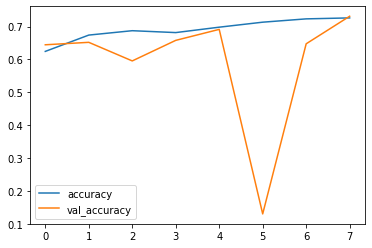

In [10]:
# create learning curves to evaluate model performance
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();